<a href="https://colab.research.google.com/github/angeloken/Riset-I-smile/blob/main/riset_prediksi_listrik_ver_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
dfull = pd.read_excel('/content/drive/MyDrive/RISET I-SMILE/Data Device Full.xlsx')
dbar = pd.read_excel('/content/drive/MyDrive/RISET I-SMILE/Data Device Sisi Barat Gd Deli.xlsx')
dtim = pd.read_excel('/content/drive/MyDrive/RISET I-SMILE/Data Device Sisi Timur Gd Deli.xlsx')

In [1]:
#import important library
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import date
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
url_tr = 'https://drive.google.com/file/d/1jI7ukSaRReUFAUMeH2jDMJRhRd7AnWtk/view?usp=sharing'
path_tr = 'https://drive.google.com/uc?export=download&id='+url_tr.split('/')[-2]
train = pd.read_csv(path_tr)
url_tst = 'https://drive.google.com/file/d/1Wu56Cp5qDX9gPoPk5k5_zUTmV9u27aO-/view?usp=sharing'
path_tst = 'https://drive.google.com/uc?export=download&id='+url_tst.split('/')[-2]
test = pd.read_csv(path_tst)

In [2]:
df = pd.read_csv('/content/opsd_germany_daily.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2006-01-01 to 2017-12-31
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         4383 non-null   datetime64[ns]
 1   Consumption  4383 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 102.7 KB


In [3]:
df = df[['Date','Consumption']]

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df.set_index(df['Date'],inplace=True)


In [12]:
df=df.drop(['Date'],axis=1)

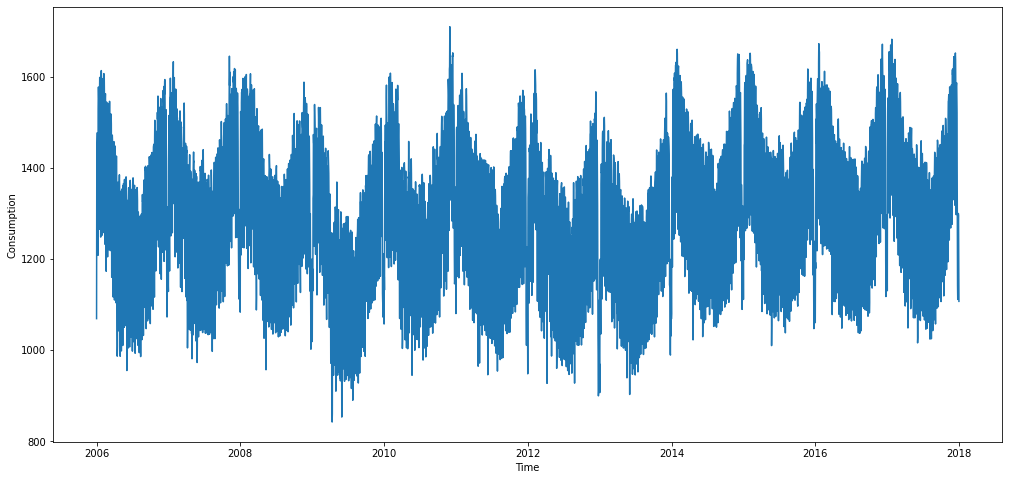

In [ ]:
def plot_data(col):
    plt.figure(figsize=(17, 8))
    plt.plot(df[col])
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.grid(False)
    plt.show()
    
for col in df.columns:
    plot_data(col)

In [13]:
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

In [14]:
df = df.reset_index()
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2006-01-01,1069.184
1,2006-01-02,1380.521
2,2006-01-03,1442.533
3,2006-01-04,1457.217
4,2006-01-05,1477.131


In [16]:
prediction_size = 30
train_df = df[:-prediction_size]

In [17]:
train_df

,ds,y
0,2006-01-01,1069.18400
1,2006-01-02,1380.52100
2,2006-01-03,1442.53300
3,2006-01-04,1457.21700
4,2006-01-05,1477.13100
...,...,...
4348,2017-11-27,1602.17797
4349,2017-11-28,1615.38061
4350,2017-11-29,1603.98435
4351,2017-11-30,1617.03309


In [18]:
m = Prophet()
m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

In [20]:
future

,ds
0,2006-01-01
1,2006-01-02
2,2006-01-03
3,2006-01-04
4,2006-01-05
...,...
4378,2017-12-27
4379,2017-12-28
4380,2017-12-29
4381,2017-12-30


In [33]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds         yhat   yhat_lower   yhat_upper
4378 2017-12-27  1387.603669  1306.543188  1472.107619
4379 2017-12-28  1373.909097  1291.535898  1455.510570
4380 2017-12-29  1348.358439  1265.291519  1429.949700
4381 2017-12-30  1157.021610  1078.397701  1242.662807
4382 2017-12-31  1064.643890   981.741074  1145.496286


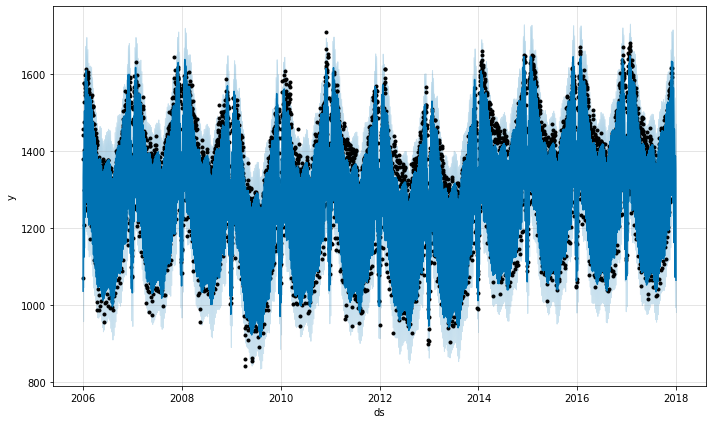

In [22]:
m.plot(forecast)
plt.show()

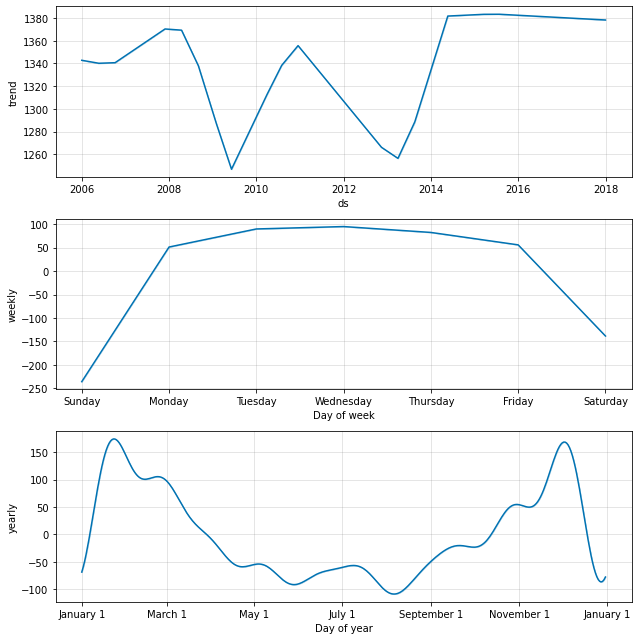

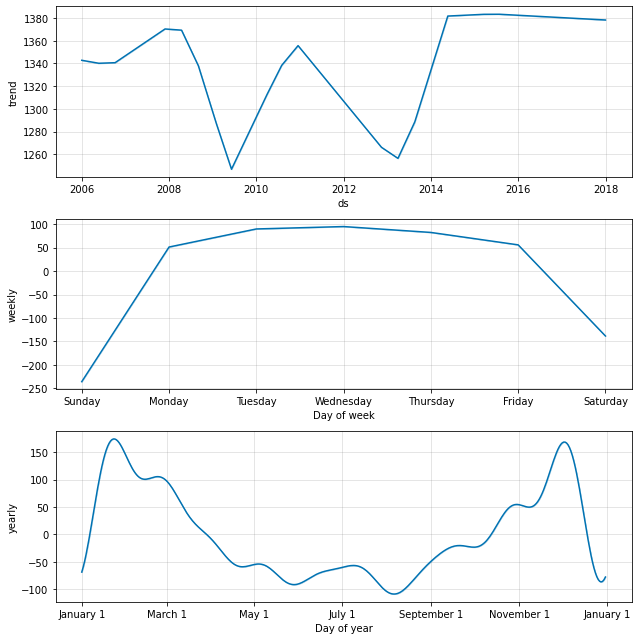

In [34]:
m.plot_components(forecast)

In [38]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [23]:
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [32]:
cmp_df = make_comparison_dataframe(df, forecast)

cmp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2017-12-27,1387.603669,1306.543188,1472.107619,1263.94091
2017-12-28,1373.909097,1291.535898,1455.510570,1299.86398
2017-12-29,1348.358439,1265.291519,1429.949700,1295.08753
2017-12-30,1157.021610,1078.397701,1242.662807,1215.44897
2017-12-31,1064.643890,981.741074,1145.496286,1107.11488


In [25]:
def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [26]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 6.035705004403182
MAE 81.81595899989246


In [28]:
!pip install prophet.diagnostics

ERROR: Could not find a version that satisfies the requirement prophet.diagnostics (from versions: none)
ERROR: No matching distribution found for prophet.diagnostics


In [29]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='1383 days', period='180 days', horizon = '365 days')

INFO:fbprophet:Making 15 forecasts with cutoffs between 2010-01-07 00:00:00 and 2016-12-01 00:00:00


In [31]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,7061.739536,84.034157,54.766619,0.043344,0.026494,0.811822
1,38 days,7023.179836,83.804414,54.905566,0.043382,0.027117,0.810969
2,39 days,6859.391209,82.821442,55.001301,0.043199,0.027595,0.806338
3,40 days,6607.008599,81.283508,54.746863,0.042635,0.027678,0.802803
4,41 days,6461.878415,80.385810,54.620158,0.042266,0.027798,0.796344


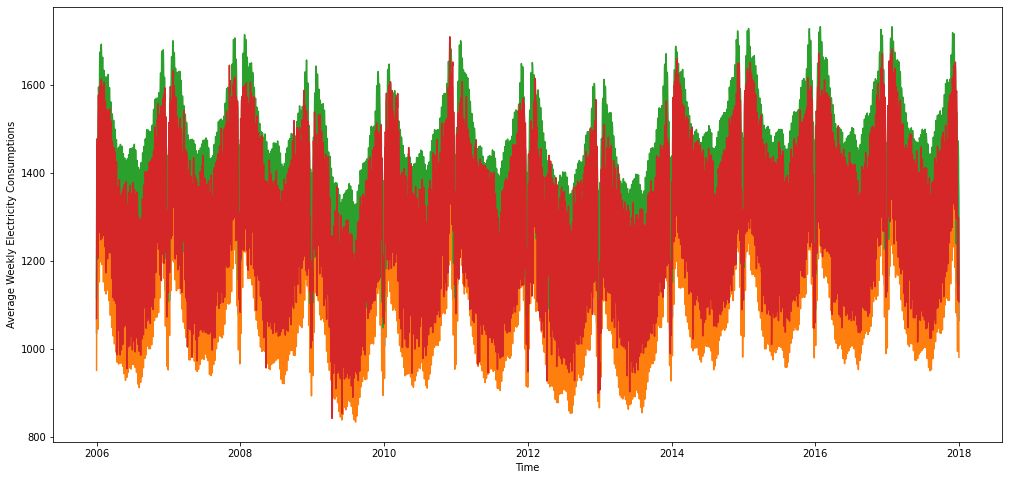

In [ ]:
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.ylabel('Average Weekly Electricity Consumptions')
plt.grid(False)
plt.show()